In [16]:
# using scann
!pip3 install scann

In [24]:
import numpy as np
import pandas as pd
import math
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix
from sklearn.decomposition import TruncatedSVD
import scann

In [25]:
config = pd.read_csv('config.csv').iloc[0]
user = config['id']
k_value = config['k']

In [26]:
with open(config['dataset_file'], 'r') as inFile:
    appreciate_data = inFile.readlines()

In [27]:
# it is to note that the user id is int, item id is string in the dataset and the user has liked the same image more than once during different time stamps
temp_all_items = set()
temp_user_likes = dict()
for line in appreciate_data:
    line = line.strip()
    user_id = int(line.split()[0])
    item_id = str(line.split()[1])

    temp_all_items.add(item_id)

    if user_id not in temp_user_likes:
        temp_user_likes[user_id] = set()
    
    temp_user_likes[user_id].add(item_id)

In [28]:
# storing all the items in sorted order
all_items = []
for item in temp_all_items:
    all_items.append(item)

all_items.sort()

user_likes = dict()
for k in temp_user_likes.keys():
    arr = []
    for item in temp_user_likes[k]:
        arr.append(item)
    arr.sort()
    user_likes[k] = arr

In [29]:
# mapping items to the index number
item_map = {}
cnt = 0
for item in all_items:
    item_map[item] = cnt
    cnt += 1

In [30]:
m = len(user_likes)
n = len(all_items)
lil = lil_matrix((m,n), dtype=bool)
r = 0
for k in user_likes.keys():
    for item in user_likes[k]:
        c = item_map[item]
        lil[r,c] = True
    r += 1

In [31]:
# SVD
svd = TruncatedSVD(n_components=2000, n_iter=5, random_state=42)
mat = svd.fit_transform(lil)

In [32]:
# here we are using k_value+1 because, the first neighbor in the list would be user itself, so to get exact K neighbor, we have added 1 there
searcher = scann.scann_ops_pybind.builder(mat, k_value+1, "dot_product").tree(num_leaves=2000, num_leaves_to_search=100, training_sample_size=250000).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [33]:
# here first we will find the vector of the user for whom we need to recommend images
r = 0
for id in user_likes.keys():
    if id == user:
        user_vector = mat[r]
        print(r)
        break
    r += 1

# here we got neighbors in ascending order
neighbors, distances = searcher.search_batched([user_vector])

0


In [34]:
# mapping neighbor index to actual user ids (because right now the neighbor ids are just the row number of the lil matrix)
idx_to_userid = {}
r = 0
for id in user_likes.keys():
  idx_to_userid[r] = id
  r += 1

neighbors_ids = []
for i in range(len(neighbors[0])):
  neighbors_ids.append(idx_to_userid[neighbors[0][i]])

In [35]:
print(neighbors_ids)

[276633, 666917, 3628520, 2492899, 3313136, 2585131]


In [37]:
# choosing top k elements and reporting the items and the user ids
# writing output to output_file  
outFile = open(config['output_file'], 'w')
for i in range(1,k_value+1):   #because the first element in the neighbor list is the user itself.
    id = neighbors_ids[i]
    print(id)
    for item in user_likes[id]:
        if item not in user_likes[user]:
            outFile.write(item + ' ' + str(id) + '\n')

outFile.close()

666917
3628520
2492899
3313136
2585131


### Explain how your choice of library works

Answer: ScaNN achieves state-of-the-art performance on the glove-100-angular dataset as shown in the graph below:

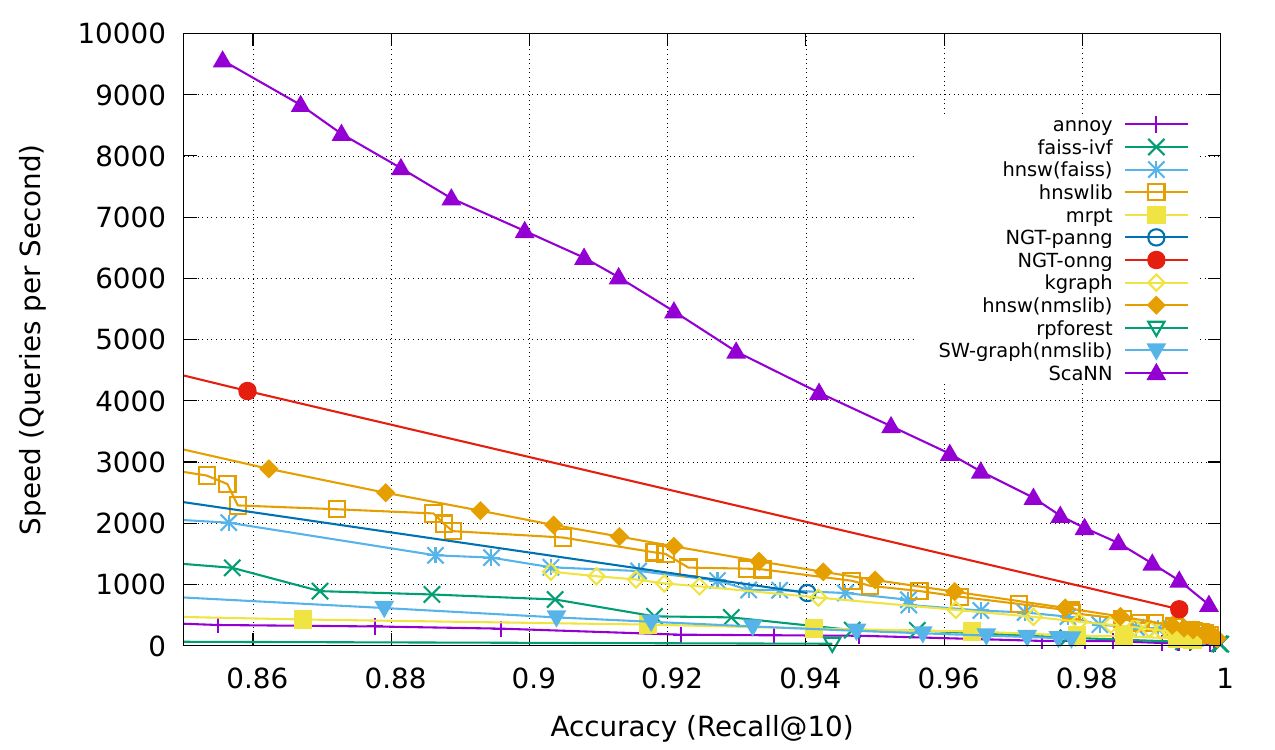

ScaNN can be configured to fit datasets with different sizes and distributions. It has both TensorFlow and Python APIs. The library shows strong performance with large datasets, hence it makes choosing ScaNN a worth it option.

### Compare your choice of library with vanilla KNN.

Answer: ScaNN works faster than vanilla KNN, so ScaNN would still be a good choice.

### Compare your choice of library with implementation of ScaNN, faiss and annoy. 

Answer:  
ScaNN :- is a vector quantization algorithm for maximum inner product search. The algorithm is a combination of product quantization, score aware loss and anisotropic loss. To accelerate the search speed, ScaNN is implemented with SIMD in-register lookup tables.

Faiss :- Faiss is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It assumes that the instances are represented as vectors and are identified by an integer, and that the vectors can be compared with L2 (Euclidean) distances or dot products. Vectors that are similar to a query vector are those that have the lowest L2 distance or the highest dot product with the query vector.

Annoy :- Annoy is a fast running algorithm which has the ability to use static files as indexes, viz. it can share index across processes. Annoy also decouples creating indexes from loading them, so it can pass around indexes as files and map them into memory quickly. It also tries to minimize memory footprint so the indexes are quite small.

Among them ScaNN is still a better choice because of Scalablity and Efficiency.

Choice:- ScaNN > Faiss > Annoy

